# Evaluation of the numerical stability of an implementation of log(1-softmax) in Pytorch

The studied function was proposed by *KFrank* in a [PyTorch forum discussion](https://discuss.pytorch.org/t/how-to-calculate-log-1-softmax-x-numerically-stably/169007/11?u=hichem).

In [1]:
from mpmath import *
import torch

# Import The numerically stable log(1-softmax) function proposed by KFrank
from log1msoftmax import log1m_softmax_kfrank

# Set float precision in the mpmath package to be equal to 2000 bits
mp.prec = 2000

# Function to compute log(1-softmax) with 2000bits precision
def log1msoftmax_pft(x : list):
    m = max(x)
    x = [i-m for i in x]
    s = sum(exp(i) for i in x)
    res = [log(1-exp(i)/s) for i in x]
    return res


# Function to compute softmax with 2000bits precision
def softmax_pft(x : list):
    m = max(x)
    x = [i-m for i in x]
    s = sum(exp(i) for i in x)
    res = [exp(i)/s for i in x]
    return res, s

# Function to compute the Jacobian of log(1-softmax) with 2000bits precision
def grad_log1msoftmax_pft(x : list):
    m = max(x)
    x = [i-m for i in x]
    res = [[0]*len(x) for _ in range(len(x))]
    sm_x, s = softmax_pft(x)
    for i in range(len(x)):
        for j in range(len(x)):
            if i == j:
                res[i][j] = -sm_x[i]
                # res[i][j] = 0
            else:
                t = sm_x[j]*s/(s-exp(x[i]))
                res[i][j] = sm_x[i]*t
                # res[i][j] = 1
    return res

# This function computes the L1 distance between each element of l1 and l2 in parallel and returns the maximum distance found.
def max_abs_dist(l1,l2):
    assert len(l1) == len(l2)
    max_error = 0
    for x,y in zip(l1,l2):
        d = abs(x - y)
        if d > max_error:
            max_error = d   
    return max_error

## Numerical stability of log1m_softmax_kfrank : Methodology

To confirm the stability and precision of the log1m_softmax_kfrank function (let’s call it KF), I compared its output and its gradient with the “real” values of the log(1-softmax).

The “real” values of log(1-softmax) are computed using the mpmath package using a ridiculously high precision (2000 bits).

The input I used is a randomly generated vector X of 100 elements on a normal distribution N(0,1) with a little modification : I set an element of X to be equal to C which varies from 0 to 100. As C grows, the sum of the exponents of X will be almost equal to exp(C) which creates the numerical instability.

We proceed to compute the maximum absolute error between KF’s output and the “real” output of log(1-softmax), noted max(abs(KF(X) - real_values)) for each value of C.

In [20]:
def get_results(v : torch.Tensor, C, func=None):
    perf_naive = []
    perf_KFrank = []
    perf_grad_KFrank = []
    v = v.clone()
    for prog, c in enumerate(C):
        print("%s/%s" % (prog, len(C)))
        v[0] = c
        b = v.clone()
        perfect = log1msoftmax_pft(b.tolist())
        naive = (1-b.softmax(-1)).log().tolist()

        
        max_grad_error = 0
        pft_grad = grad_log1msoftmax_pft(b.tolist())
        for i in range(len(v)):
            b = v.clone().requires_grad_()
            KFrank = log1m_softmax_kfrank(b)
            KFrank[i].backward()
            maxi = max_abs_dist(pft_grad[i],b.grad.tolist())
            if maxi > max_grad_error:
                max_grad_error = maxi

        perf_naive.append(max_abs_dist(perfect, naive))
        perf_KFrank.append(max_abs_dist(perfect, KFrank.tolist()))
        perf_grad_KFrank.append(max_grad_error)
    return perf_naive, perf_KFrank, perf_grad_KFrank


In [21]:
a = torch.randn(100)
C = np.linspace(0,200,400)
perf_naive, perf_KFrank, perf_grad_KFrank = get_results(a,C)

0/400
1/400
2/400
3/400
4/400
5/400
6/400
7/400
8/400
9/400
10/400
11/400
12/400
13/400
14/400
15/400
16/400
17/400
18/400
19/400
20/400
21/400
22/400
23/400
24/400
25/400
26/400
27/400
28/400
29/400
30/400
31/400
32/400
33/400
34/400
35/400
36/400
37/400
38/400
39/400
40/400
41/400
42/400
43/400
44/400
45/400
46/400
47/400
48/400
49/400
50/400
51/400
52/400
53/400
54/400
55/400
56/400
57/400
58/400
59/400
60/400
61/400
62/400
63/400
64/400
65/400
66/400
67/400
68/400
69/400
70/400
71/400
72/400
73/400
74/400
75/400
76/400
77/400
78/400
79/400
80/400
81/400
82/400
83/400
84/400
85/400
86/400
87/400
88/400
89/400
90/400
91/400
92/400
93/400
94/400
95/400
96/400
97/400
98/400
99/400
100/400
101/400
102/400
103/400
104/400
105/400
106/400
107/400
108/400
109/400
110/400
111/400
112/400
113/400
114/400
115/400
116/400
117/400
118/400
119/400
120/400
121/400
122/400
123/400
124/400
125/400
126/400
127/400
128/400
129/400
130/400
131/400
132/400
133/400
134/400
135/400
136/400
137/400
138/40

The next image is a plot of the maximum absolute error between KF’s output and the “real” output of log(1-softmax), noted max(abs(KF(X) - real_values)), with respect to C. I also plotted the naive implementation torch.log(1-torch.softmax(X)) for reference. As we can see, KF stays stable and accurate while the “naive” approach diverges to infinity after C ≈ 25. The maximum absolute error of KF, reported in this test, is approximately 6.56e-6.

Maximum MAE (ours) = 6.561922861487168616e-6
Maximum MAE (KFrank) = 6.561922861487168616e-6


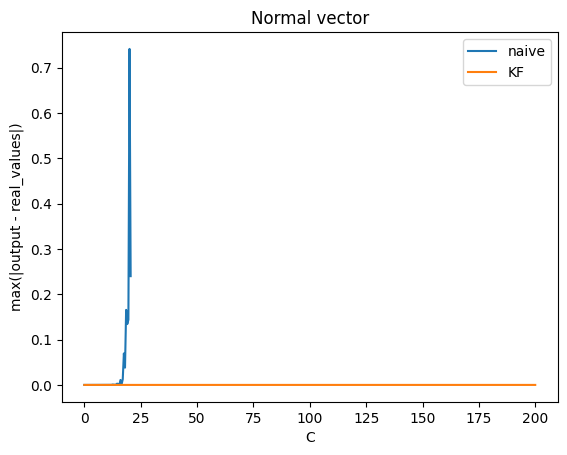

In [27]:
import matplotlib.pyplot as plt

plt.plot(C, perf_naive, label='naive')
plt.plot(C, perf_KFrank, label='KF')
plt.legend()
plt.xlabel('C')
plt.ylabel('max(|output - real_values|)')
plt.title('Normal vector')

print("Maximum MAE (KFrank) = %s" % nstr(max(perf_KFrank), 20))

Same observation when comparing the Jacobian of KF with the "real" Jacobian of the log(1-softmax) function. The maximum absolute error of KF, reported in this test, is approximately 6.79e-6.

Maximum MAE on gradient (KFrank) = 6.794929504e-6


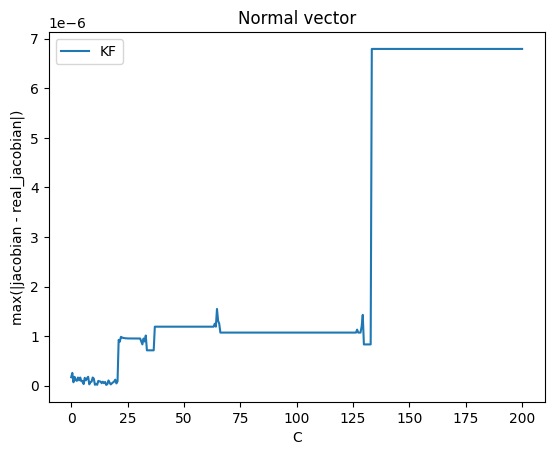

In [30]:
plt.plot(C, perf_grad_KFrank, label='KF')
plt.legend()
plt.xlabel('C')
plt.ylabel('max(|jacobian - real_jacobian|)')
plt.title('Normal vector')

print("Maximum MAE on gradient (KFrank) = %s" % nstr(max(perf_grad_KFrank), 10))